# Import

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load the data

Le [dataset](https://www.kaggle.com/datasets/hubertsidorowicz/football-players-stats-2024-2025) contient les perfomrances et statistiques des joueurs de football des 5 grands championnats européens (Premier League, La Liga, Serie A, Bundesliga et Ligue 1) pour la saison 2024/2025. Les statistiques ont été récupérées par l'auteur du dataset à partir du site [FBref](https://fbref.com/en/). A ce tableau nous avons ajouté les valeurs marchandes des joueurs, récupérées sur le site [Transfermarkt](https://www.transfermarkt.com/) ainsi que les fins de contrat des joueurs, récupérées sur le site [sofifa.com](https://www.sofifa.com/). Le code qui a permis de construire le dataset est disponible dans le dossier scrap. Le dataset contient 1887 joueurs. 

L’objectif de ce projet est de prédire la valeur marchande `market_value` d’un joueur de football professionnel à partir de ses caractéristiques et de ses performances. Cette tâche constitue un problème de régression supervisée, où l’on cherche à estimer la valeur en euros en fonction de plusieurs centaines de features. Ces features incluent notamment les statistiques de jeu (temps de jeu, buts, passes, tacles, interceptions, etc.), les données physiques, contractuelles, géographiques, ou encore les performances avancées. Une description complète des features utilisées se trouve dans le fichier `features.md` du repo. Néanmoins, le dataset contient beaucoup de features qui ne sont pas tous pertinentes.

Résoudre ce problème est particulièrement intéressant dans le contexte de l’industrie du football, car la valeur marchande d’un joueur influence de nombreuses décisions stratégiques : recrutement, ventes, négociations contractuelles, gestion des actifs ou encore modélisation financière des clubs. Un outil prédictif fiable peut donc **aider les clubs à identifier des joueurs sous-évalués** ou à **améliorer la transparence des valorisations** sur le marché des transferts.

In [12]:
data = pd.read_csv('merged_data_clean.csv')
data.dropna(subset=["market_value"], inplace=True)

Le dataset comporte un grand nombre de features. Une phase d’analyse exploratoire et de nettoyage des données est donc nécessaire afin d’identifier les variables pertinentes, détecter d’éventuelles anomalies et préparer le jeu de données à l’entraînement des modèles.


# Analyze and Clean the Data


Au cours d'une saison de football, les joueurs peuvent changer de club en milieu de saison. Cela se traduit dans le jeu de données initial par des joueurs dupliqués, chaque ligne représentant les performances du joueur lors de la saison dans un club spécifique. Puisque nous avons récupéré les valeurs marchandes à la fin de la saison 2024/2025, nous avons décidé de ne considérer que les joueurs ayant joué toute la saison avec la même équipe.

In [13]:
data = data.drop_duplicates(subset=["Player"])
print(len(data))

1887


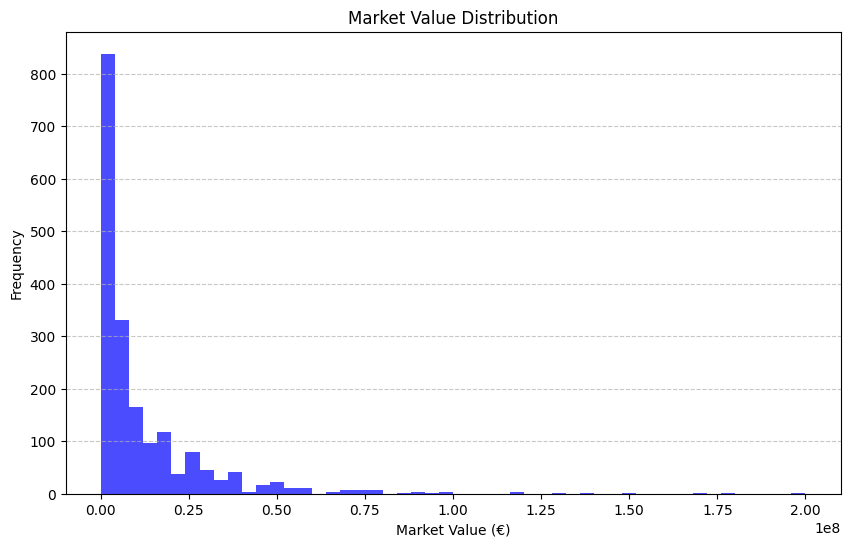

In [14]:
plt.figure(figsize=(10, 6))
data['market_value'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Market Value Distribution')
plt.xlabel('Market Value (€)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
market_value_mean = data['market_value'].mean()
market_value_median = data['market_value'].median()
market_value_min = data['market_value'].min()
market_value_std = data['market_value'].std()
print(f"Mean Market Value: €{market_value_mean:,.2f}")
print(f"Median Market Value: €{market_value_median:,.2f}")
print(f"Minimum Market Value: €{market_value_min:,.2f}")
print(f"Standard Deviation of Market Value: €{market_value_std:,.2f}")

top_10_players = data.nlargest(10, 'market_value')
print("Top 10 Players by Market Value:")
print(top_10_players[['Player', 'market_value']])

Mean Market Value: €12,539,666.14
Median Market Value: €5,000,000.00
Minimum Market Value: €100,000.00
Standard Deviation of Market Value: €18,731,556.53
Top 10 Players by Market Value:
               Player  market_value
2     Vinicius Júnior   200000000.0
1     Jude Bellingham   180000000.0
33       Lamine Yamal   180000000.0
3       Kylian Mbappé   170000000.0
12        Bukayo Saka   150000000.0
6       Florian Wirtz   140000000.0
11      Jamal Musiala   140000000.0
13  Federico Valverde   130000000.0
19        Cole Palmer   120000000.0
23        Declan Rice   120000000.0


Les joueurs avec une forte valeur marchande tirent les valeurs vers le haut.

In [16]:
mean_market_value_per_league = data.groupby("Comp")["market_value"].mean()
print(mean_market_value_per_league.sort_values(ascending=False))

Comp
eng Premier League    2.233210e+07
es La Liga            1.146806e+07
de Bundesliga         9.902480e+06
it Serie A            8.722941e+06
fr Ligue 1            8.645215e+06
Name: market_value, dtype: float64


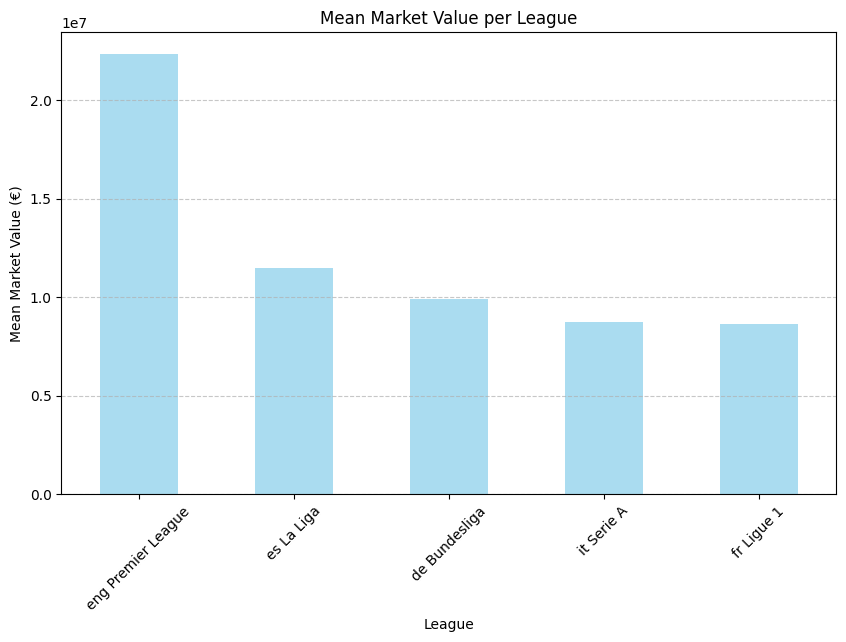

In [17]:
plt.figure(figsize=(10, 6))
mean_market_value_per_league.sort_values(ascending=False).plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Mean Market Value per League')
plt.xlabel('League')
plt.ylabel('Mean Market Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
number_players_per_league = data["Comp"].value_counts()
print("Number of Players per League:")
print(number_players_per_league)

Number of Players per League:
Comp
eng Premier League    426
it Serie A            425
de Bundesliga         373
es La Liga            360
fr Ligue 1            303
Name: count, dtype: int64


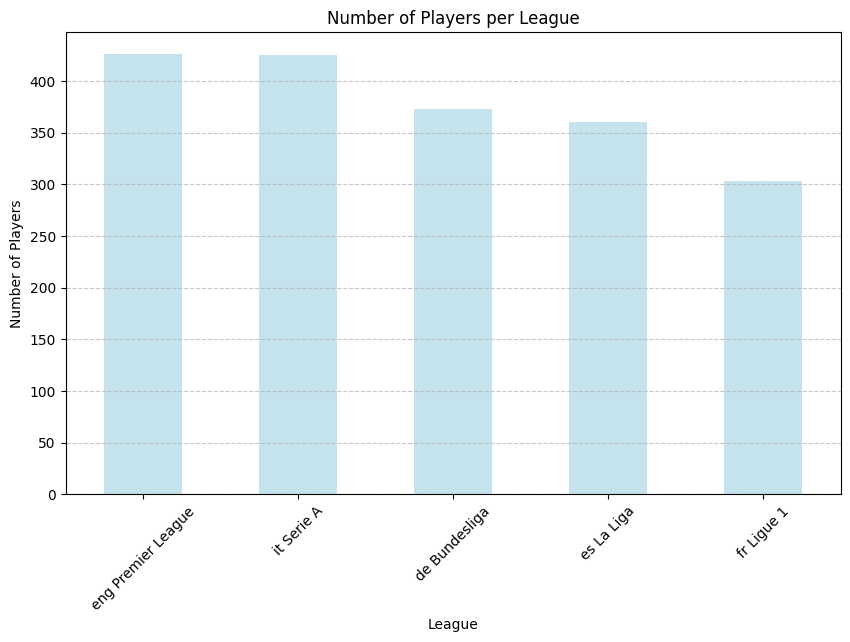

In [19]:
plt.figure(figsize=(10, 6))
number_players_per_league.plot(kind='bar', color='lightblue', alpha=0.7)
plt.title('Number of Players per League')
plt.xlabel('League')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque que pour une répartiton assez similaire du nombres de joueurs par championnat, il y a une forte disparité dans les valeurs marchandes des joueurs en fonction du championnat. La Premier League est le championnat avec les valeurs marchandes les plus élevées, suivie de la Liga et de la Serie A. La Bundesliga et la Ligue 1 ont des valeurs marchandes plus faibles en moyenne. Le championnat dans lequel évolue le joueur pourrait etre une feature importante à prendre en compte dans la prédiction de la valeur marchande du joueur.

In [20]:
std_per_league = data.groupby("Comp")["market_value"].std()
print("Standard Deviation of Market Value per League:")
print(std_per_league.sort_values(ascending=False))

Standard Deviation of Market Value per League:
Comp
es La Liga            2.377237e+07
eng Premier League    2.117774e+07
de Bundesliga         1.594336e+07
fr Ligue 1            1.383892e+07
it Serie A            1.201524e+07
Name: market_value, dtype: float64


In [21]:
premier_league_data = data[data["Comp"] == "eng Premier League"]

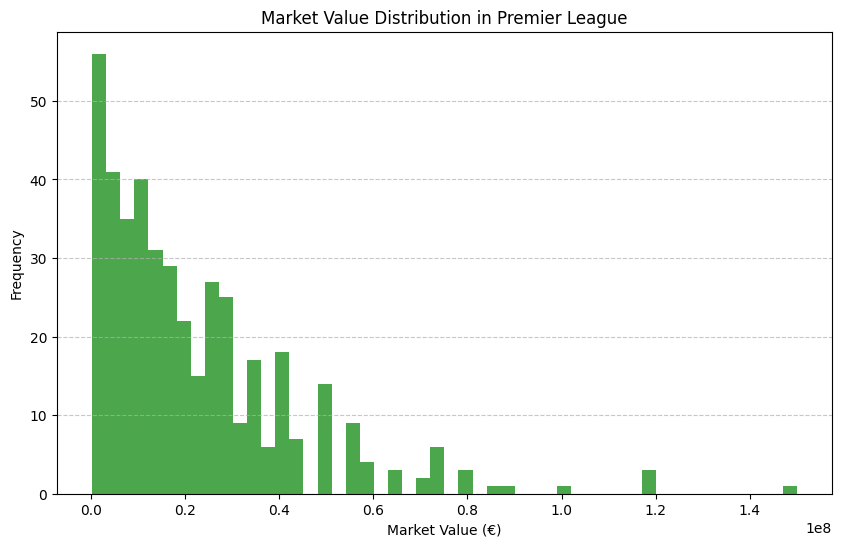

In [22]:
plt.figure(figsize=(10, 6))
premier_league_data['market_value'].plot(kind='hist', bins=50, color='green', alpha=0.7)
plt.title('Market Value Distribution in Premier League')
plt.xlabel('Market Value (€)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

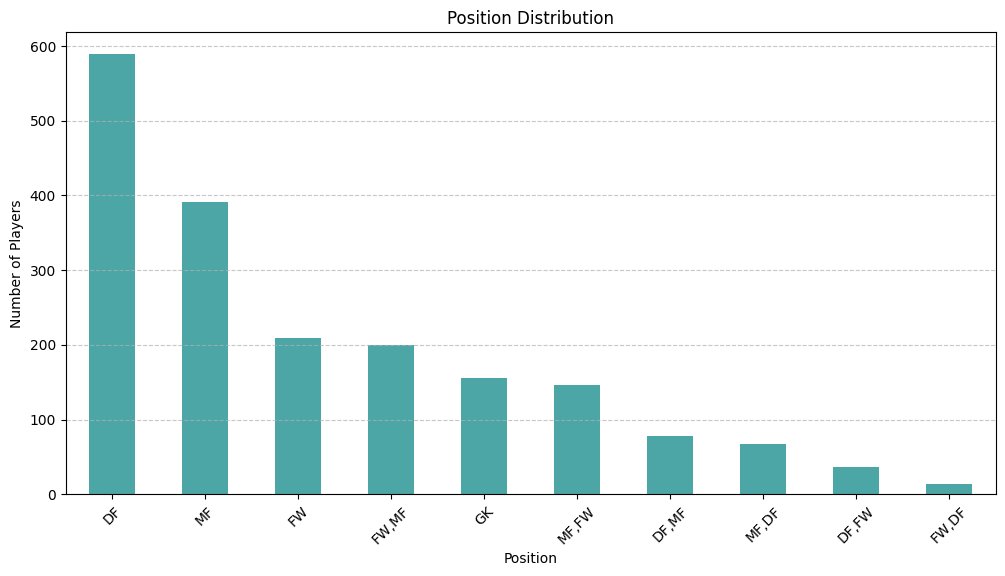

In [23]:
position_distribution = data['Pos'].value_counts()
position_distribution.plot(kind='bar', figsize=(12, 6), color='teal', alpha=0.7)
plt.title('Position Distribution')
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Etant donnée la nature des statistiques entre les joueurs de champs et le gardien très différente et que le nous avons plus de joueurs de champs, nous avons décidé de ne pas prendre en compte les gardiens dans notre modèle. On oublie pas de supprimer également les statistiques uniquements liés aux gardiens comme le nombre d'arrets. On  remarque que les joueurs de champs peuvent avoir joués à plusieurs positions. Nous dupliqué les joueurs avec plusieurs positions, chaque ligne correspond à une poste.

In [24]:
data = data[data['Pos'] != 'GK']
cols_to_drop = [col for col in data.columns if "stats_keeper" in col or "GK" in col or "(GK)" in col]
data.drop(columns=cols_to_drop, inplace=True)
gk_cols = [
    "PSxG+/-", "CS", "Stp%", "Launch%", "Save%", "Saves", "CS%", "AvgDist",
    "GA90", "GA", "Thr", "D", "PSxG", "SoTA", "AvgLen", "Stp", "/90",
    "PSxG/SoT", "#OPA", "PKm", "PKsv", "#OPA/90", "PKA", "Opp","W","L"
]
data.drop(columns=gk_cols, inplace=True)


In [25]:
data['Pos']

0          FW
1          MF
2          FW
3          FW
4          DF
        ...  
2328       MF
2329       MF
2330       DF
2332       DF
2333    FW,MF
Name: Pos, Length: 1731, dtype: object

In [26]:
data = data.assign(Pos=data["Pos"].str.split(",")).explode("Pos").reset_index(drop=True)

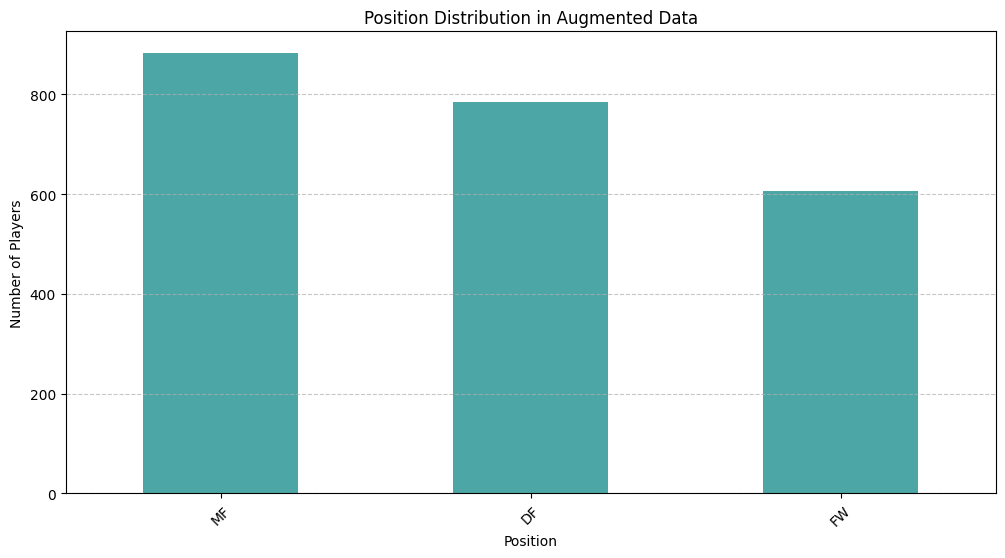

In [27]:
plt.figure(figsize=(12, 6))
data['Pos'].value_counts().plot(kind='bar', color='teal', alpha=0.7)
plt.title('Position Distribution in Augmented Data')
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

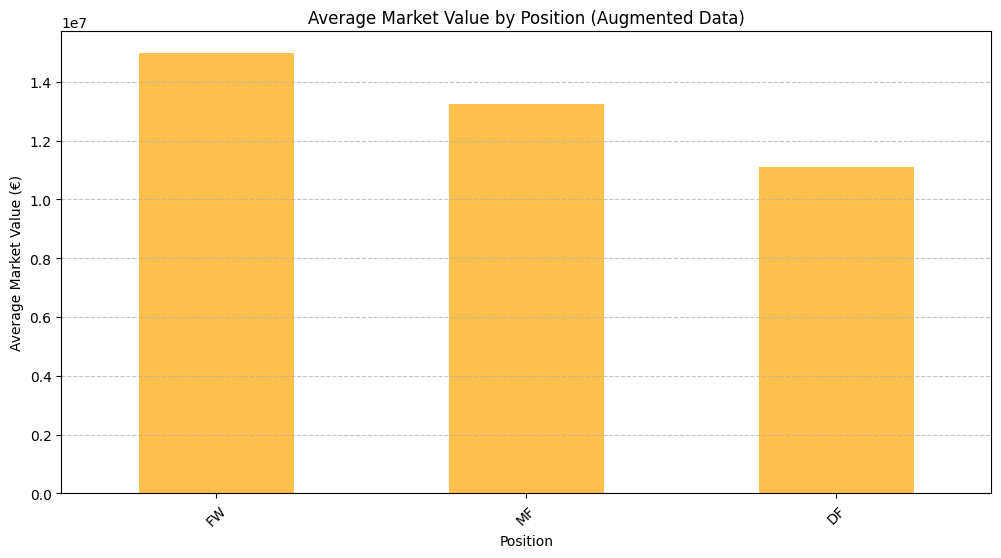

In [28]:
average_market_value_augmented = data.groupby('Pos')['market_value'].mean()

plt.figure(figsize=(12, 6))
average_market_value_augmented.sort_values(ascending=False).plot(kind='bar', color='orange', alpha=0.7)
plt.title('Average Market Value by Position (Augmented Data)')
plt.xlabel('Position')
plt.ylabel('Average Market Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque que les attaquants ont une valeurs marchande moyenne la plus élevées mais ils sont aussi qui sont le moins représentés dans le dataset.

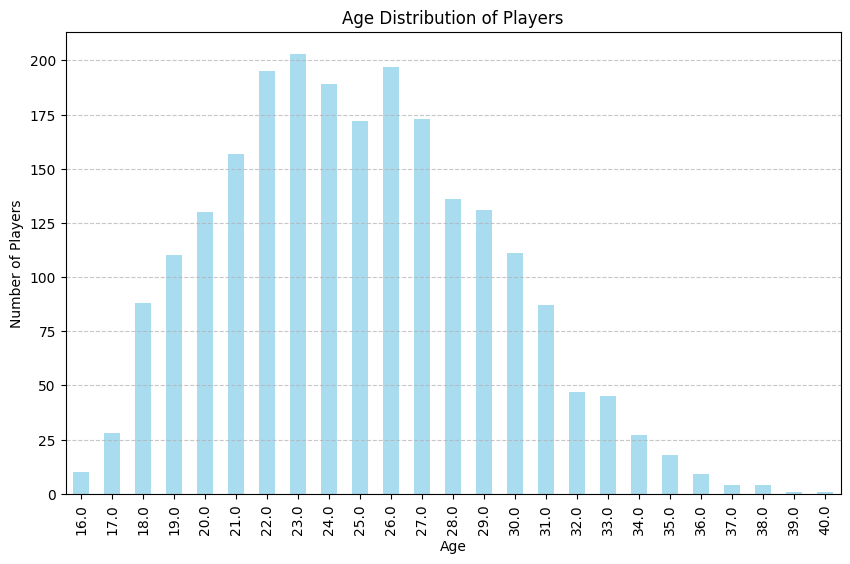

In [29]:
plt.figure(figsize=(10, 6))
data['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

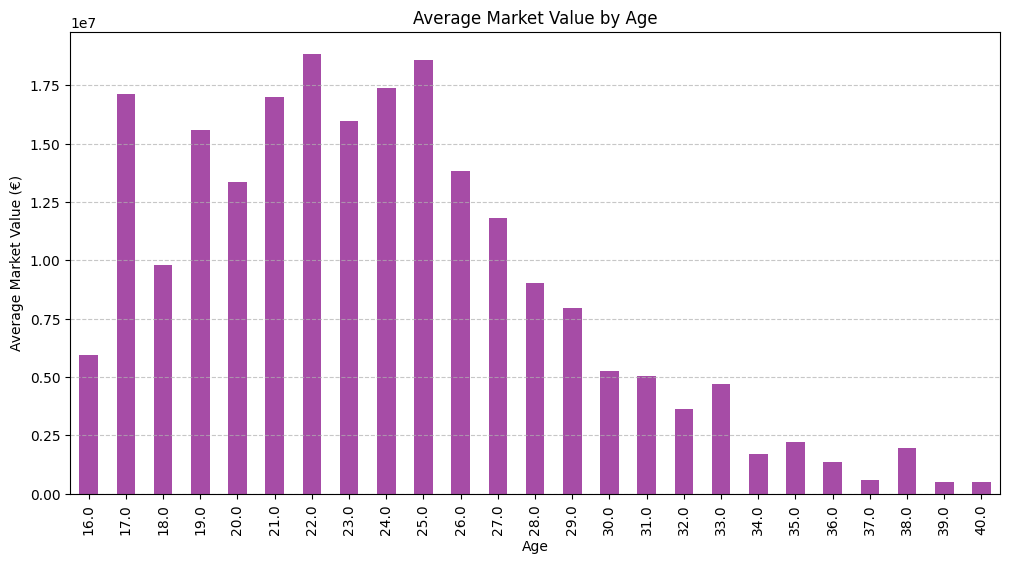

In [30]:
grouped_age_data = data.groupby("Age")["market_value"].mean()
grouped_age_data.plot(kind='bar', figsize=(12, 6), color='purple', alpha=0.7)
plt.title('Average Market Value by Age')
plt.xlabel('Age')
plt.ylabel('Average Market Value (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

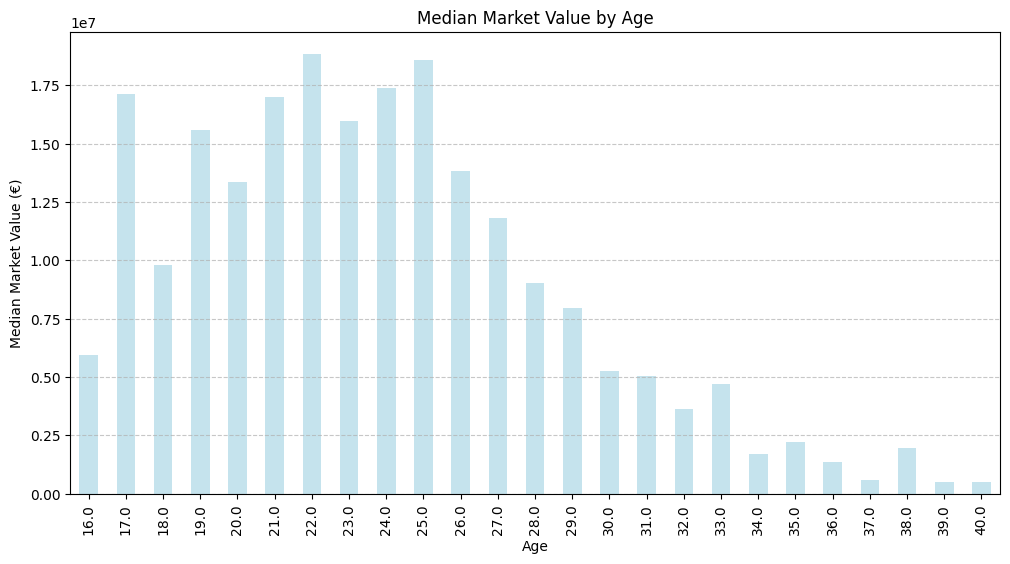

In [31]:
plt.figure(figsize=(12, 6))
grouped_age_data.plot(kind='bar', color='lightblue', alpha=0.7)
plt.title('Median Market Value by Age')
plt.xlabel('Age')
plt.ylabel('Median Market Value (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque un grand pic de valeur pour les joueurs 16 et 17 ans alors qu'il ont une faible parti du dataset. On pourrait penser que cette partie du dataset est biaisée et que cette tranche d'age ne peut etre utilisé en feature. Cependant après des recherches il s'avère que les joueurs qui arrivent à devenir professionnels à cet age sont très rares et que leur valeur marchande est très élevée. Sachant que les joueurs signent leur premier contrat pro en général entre 16 et 19 ans. Leur précocités et leur potentiel est fortement valorisé. Il s'agit donc d'une partie du dataset qui est pertinente pour la prédiction de la valeur marchande des joueurs. On remarque une forte chute des valeurs marchances à partir de 26 ans puis à partir de 30 ans.

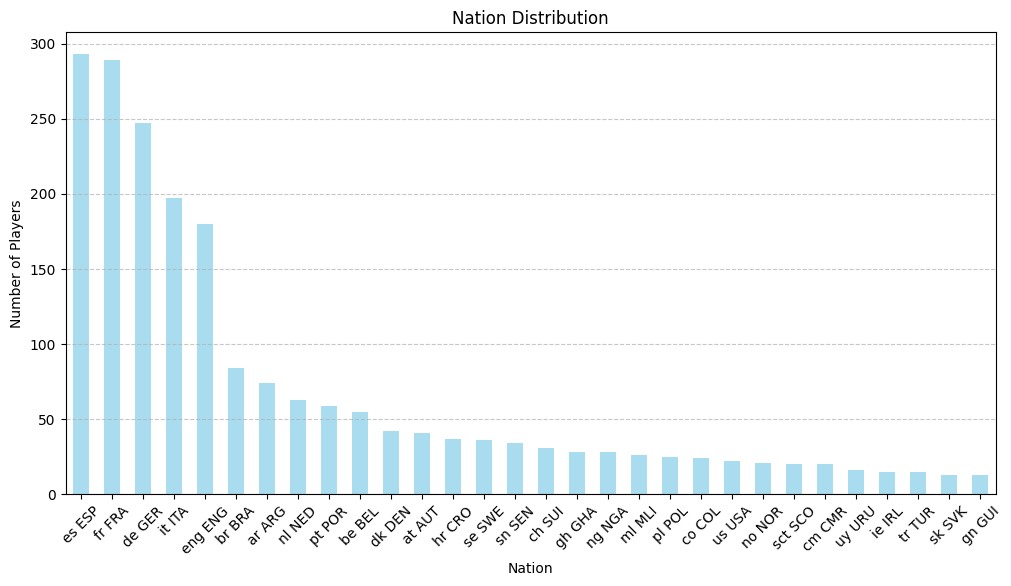

In [32]:
nation_distribution = data['Nation'].value_counts()
nation_distribution.head(30).plot(kind='bar', figsize=(12, 6), color='skyblue', alpha=0.7)
plt.title('Nation Distribution')
plt.xlabel('Nation')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
continent_mapping = {
    'ENG': 'Europe', 'ESP': 'Europe', 'IRL': 'Europe', 'FRA': 'Europe', 'MAR': 'Africa',
    'ALG': 'Africa', 'EGY': 'Africa', 'TUN': 'Africa', 'KSA': 'Asia', 'DEN': 'Europe',
    'BRA': 'South America', 'ITA': 'Europe', 'NGA': 'Africa', 'SCO': 'Europe', 'USA': 'North America',
    'AUT': 'Europe', 'GER': 'Europe', 'CIV': 'Africa', 'MNE': 'Europe', 'SUI': 'Europe',
    'SWE': 'Europe', 'GHA': 'Africa', 'NOR': 'Europe', 'ROU': 'Europe', 'NED': 'Europe',
    'ARG': 'South America', 'PAR': 'South America', 'GAB': 'Africa', 'POR': 'Europe', 'MEX': 'North America',
    'SEN': 'Africa', 'PAN': 'North America', 'PUR': 'North America', 'JAM': 'North America', 'URU': 'South America',
    'VEN': 'South America', 'HAI': 'North America', 'ISL': 'Europe', 'JPN': 'Asia', 'ALB': 'Europe',
    'COL': 'South America', 'TOG': 'Africa', 'IDN': 'Asia', 'GUI': 'Africa', 'CRO': 'Europe',
    'SLE': 'Africa', 'CAN': 'North America', 'COD': 'Africa', 'CMR': 'Africa', 'HUN': 'Europe',
    'ZAM': 'Africa', 'CZE': 'Europe', 'BEL': 'Europe', 'TUR': 'Asia', 'SUR': 'South America',
    'POL': 'Europe', 'SVK': 'Europe', 'GNB': 'Africa', 'SVN': 'Europe', 'MLI': 'Africa',
    'NIR': 'Europe', 'SRB': 'Europe', 'CHI': 'South America', 'WAL': 'Europe', 'AUS': 'Oceania',
    'NZL': 'Oceania', 'ECU': 'South America', 'LUX': 'Europe', 'GAM': 'Africa', 'CGO': 'Africa',
    'BAN': 'Asia', 'EQG': 'Africa', 'CPV': 'Africa', 'GEO': 'Asia', 'MTQ': 'North America',
    'BIH': 'Europe', 'MKD': 'Europe', 'BFA': 'Africa', 'GRE': 'Europe', 'UKR': 'Europe',
    'CRC': 'North America', 'LTU': 'Europe', 'RUS': 'Europe', 'DOM': 'North America', 'IRQ': 'Asia',
    'KOR': 'Asia', 'PHI': 'Asia', 'BEN': 'Africa', 'FIN': 'Europe', 'EST': 'Europe',
    'ZIM': 'Africa', 'ISR': 'Asia', 'CYP': 'Asia', 'UZB': 'Asia', 'ANG': 'Africa',
    'CTA': 'Africa', 'GLP': 'North America', 'MAD': 'Africa', 'PER': 'South America',
    'GUF': 'South America', 'MOZ': 'Africa', 'ARM': 'Asia', 'KVX': 'Europe', 'LBY': 'Africa',
    'BDI': 'Africa', 'KEN': 'Africa', 'COM': 'Africa', 'MDA': 'Europe', 'MSR': 'North America',
    'JOR': 'Asia', 'IRN': 'Asia', 'MLT': 'Europe'
}
def get_continent_from_alpha3(country_alpha3):
    return continent_mapping.get(country_alpha3, None)
data['continent'] = data["Nation"].apply(lambda x: get_continent_from_alpha3(x.split(" ")[-1]) if pd.notna(x) else None)

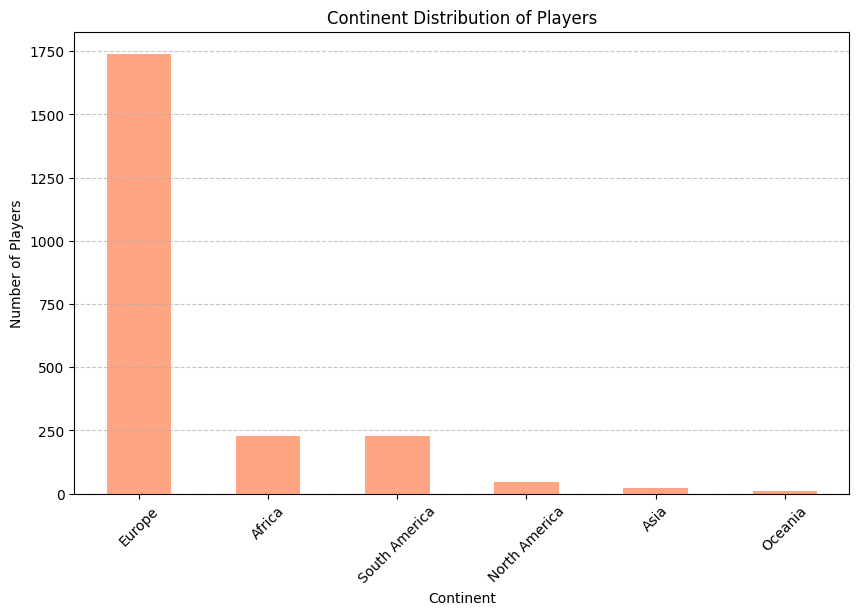

Continent Distribution:
continent
Europe           1740
Africa            227
South America     227
North America      45
Asia               24
Oceania             9
Name: count, dtype: int64


In [34]:
continent_distribution = data['continent'].value_counts()
continent_distribution.plot(kind='bar', figsize=(10, 6), color='coral', alpha=0.7)
plt.title('Continent Distribution of Players')
plt.xlabel('Continent')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Continent Distribution:")
print(continent_distribution)

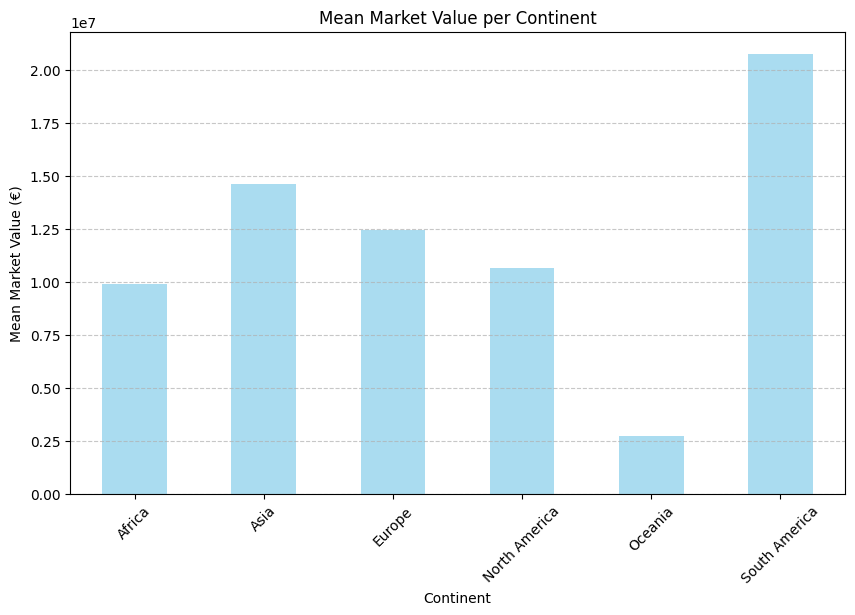

Mean Market Value per Continent:
continent
South America    €20,767,180.62
Asia             €14,600,000.00
Europe           €12,433,764.37
North America    €10,654,444.44
Africa            €9,917,621.15
Oceania           €2,744,444.44
Name: market_value, dtype: object


In [35]:

mean_market_value_per_continent = data.groupby('continent')['market_value'].mean()

plt.figure(figsize=(10, 6))
mean_market_value_per_continent.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Mean Market Value per Continent')
plt.xlabel('Continent')
plt.ylabel('Mean Market Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Mean Market Value per Continent:")
print(mean_market_value_per_continent.sort_values(ascending=False).apply(lambda x: f"€{x:,.2f}"))

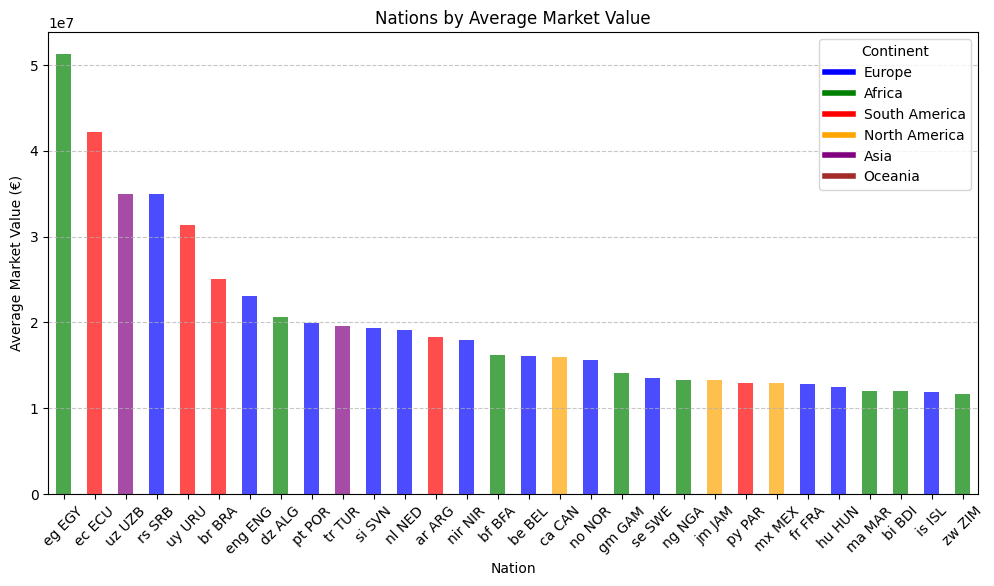

In [36]:
# Define colors for each continent
continent_colors = {
    'Europe': 'blue',
    'Africa': 'green',
    'South America': 'red',
    'North America': 'orange',
    'Asia': 'purple',
    'Oceania': 'brown'
}

# Group data by nation and calculate the average market value
grouped_nation_data = data.groupby("Nation")["market_value"].mean().sort_values(ascending=False)

# Map colors to continents
grouped_nation_data_colors = grouped_nation_data.index.map(
    lambda nation: continent_colors.get(
        data[data['Nation'] == nation]['continent'].iloc[0]
        if not data[data['Nation'] == nation]['continent'].empty else None,
        'gray'
    )
)

# Plot with colors
ax = grouped_nation_data.head(30).plot(kind='bar', figsize=(12, 6), color=grouped_nation_data_colors, alpha=0.7)
plt.title('Nations by Average Market Value')
plt.xlabel('Nation')
plt.ylabel('Average Market Value (€)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend for colors
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in continent_colors.values()]
labels = continent_colors.keys()
plt.legend(handles, labels, title="Continent", loc='upper right')

plt.show()

On remarque que les joueurs egyptiens sont ceux qui ont la valeur marchande la plus élevé en moyenne. Mais cela est du au faible nombre de joueur egyptiens dans le dataset. En effet, il n'y a que 3 joueurs égyptiens dans le dataset, ce qui peut fausser la moyenne. La nationalité du joueur ne semble pas être une feature pertinente à prendre en compte dans la prédiction de la valeur marchande du joueur dans ce dataset. 

En revanche si l'on regarde par continent on remarque des choses intéréssantes malgré les  disparités de nombre de joueurs par continent. On remarque que pour une distribution assez similaire, les joueurs sud-américains ont une valeur marchandes moyenne bien plus elevés que les africains. Etre sud americain pourrait etre une feature pertinente à prendre en compte dans la prédiction de la valeur marchande du joueur.

In [37]:
data.drop(columns=['Nation'],inplace=True)

Pour exploiter efficacement la variable `club_contract_valid_until`, qui contient la date d’expiration du contrat d’un joueur, nous avons choisi de la transformer en une variable numérique  appelée `years_left`.
Cela fournit une mesure du temps restant sur le contrat d’un joueur, ce qui peut être un facteur explicatif important de sa valeur marchande.

In [38]:
from datetime import datetime
import pandas as pd

def extract_year(val):
    try:
        # Si c'est une année au format "2027", convertir directement
        if str(val).isdigit():
            return int(val)
        # Essayer de parser une date complète (ex: "Jun 30, 2025")
        date = pd.to_datetime(val, errors='coerce')
        if pd.isna(date):
            return None
        return date.year
    except:
        return None

# Appliquer la fonction à chaque ligne
data['contract_year'] = data['club_contract_valid_until'].apply(extract_year)

current_year = 2025
data['years_left'] = data['contract_year'] - current_year
data.drop(columns=['club_contract_valid_until', 'contract_year'], inplace=True)
data.dropna(subset=['years_left'], inplace=True)


Nous allons encoder le `preferred_foot`

In [39]:
data["preferred_foot"] = data["preferred_foot"].map({"Right": 1, "Left": 0})

Les colonnes suivantes ont été supprimées du dataset :

- `normalized_player`, `normalized_full_name`, `full_name`, `Player` : identifiants ou noms des joueurs, inutiles pour la modélisation.
- `dob`, `Age`, `birth_year_y` : informations redondantes avec `birth_year_x` déjà conservée.
- `Squad`, `Comp` : métadonnées sur l'équipe ou la compétition, peu informatives dans notre contexte.
- `last_evaluation` : trop spécifique et potentiellement corrélée directement à la cible.

Ces variables ne sont pas exploitables directement par un modèle, ou bien elles **doublonnent des informations déjà présentes**.

In [40]:
data.drop(["normalized_player", "normalized_full_name", "full_name", "dob", "Age", "birth_year_y", "Player", "Squad", "Comp", "last_evaluation","value_updated","success"], axis=1, inplace=True)

Les colonnes contenant des statistiques dérivées associées à `Pos`, `Nation`, `Comp`, `Age` et `Born` ont été supprimées afin d’éviter les redondances. Seules la colonne principale comme `Pos` ont été conservées. Ces suppressions permettent de simplifier le jeu de données sans perte d'information essentielle.


In [41]:
columns_to_drop = [col for col in data.columns if "Pos" in col and col != "Pos"]
data.drop(columns=columns_to_drop, inplace=True)

In [42]:
columns_to_drop = [col for col in data.columns if "Nation" in col]
data.drop(columns=columns_to_drop, inplace=True)

In [43]:
columns_to_drop = [col for col in data.columns if "Comp" in col and col != "Comp"]
data.drop(columns=columns_to_drop, inplace=True)

In [44]:
columns_to_drop = [col for col in data.columns if "Age" in col or "Born" in col]
data.drop(columns=columns_to_drop, inplace=True)

Les valeurs manquantes des colonnes numériques ont été remplacées par la moyenne, calculée groupe par groupe selon la position (`Pos`) du joueur. Cette méthode permet de conserver les variations structurelles propres à chaque poste, tout en évitant de supprimer des lignes ou de biaiser la distribution globale des variables.


In [45]:
def fill_missing_values(data):
    for col in data.select_dtypes(include='number').columns:
        if data[col].isnull().any():
            data[col] = data.groupby('Pos')[col].transform(lambda x: x.fillna(x.mean()))
    return data

data = fill_missing_values(data)

Les colonnes contenant des statistiques rapportées sur 90 minutes (`/90`, `90s_`, ou se terminant par `90`) ont été supprimées. Elles sont souvent redondantes avec les totaux bruts et peuvent introduire du bruit ou des doublons dans la modélisation.


In [46]:
cols_to_drop_90 = [
    col for col in data.columns
    if '/90' in col or '90s_' in col or col.endswith('90')
]
data.drop(columns=cols_to_drop_90, inplace=True)




Les colonnes `Pos` et `continent` ont été converties en variables numériques pour que le modèle puisse les utiliser.


In [47]:
data = pd.get_dummies(data, columns=["Pos","continent"], prefix=["Pos","continent"])


Voici un résumé des features qu'on a gardé

| **Catégorie**                  | **Exemples de colonnes**                                                                                      | **Rôle / intérêt pour la modélisation**                                                                 |
|-------------------------------|----------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| **Cible**                     | `market_value`                                                                                                | Valeur marchande à prédire.                                                                             |
| **Identité / morphologie**    | `height_cm`, `weight_kg`, `preferred_foot`, `weak_foot`, `birth_year_x`                                       | Informations personnelles influençant le poste, style ou potentiel physique.                            |
| **Situation contractuelle**   | `years_left`                                                                                                  | Durée restante de contrat, potentiellement liée à la valeur.                                            |
| **Position (one-hot)**        | `Pos_DF`, `Pos_MF`, `Pos_FW`                                                                                  | Encodage des postes, utile pour comparer les joueurs d’un même rôle.                                    |
| **Origine géographique**      | `continent_*`                                                                                                 | Localisation, peut influencer le marché, la formation ou la visibilité.                                 |
| **Temps de jeu**              | `MP`, `Min`, `Min%`, `MP_stats_playing_time`, `Starts`, `Subs`, `unSub`, `Mn/MP`, `Mn/Start`, `Mn/Sub`, `90s` | Indicateurs de temps de jeu, titularisation, remplacements.                                             |
| **Performance offensive**     | `Gls`, `xG`, `G/Sh`, `G/SoT`, `G-PK`, `G-xG`, `xG+xAG`, `npxG`, `npxG+xAG`, `G+A`, `G+A-PK`, `SoT`, `SoT%`      | Contribution directe au score et qualité de finition.                                                   |
| **Création d’occasions**      | `Ast`, `xA`, `xAG`, `xAG_stats_passing`, `SCA`, `GCA`, `KP`, `A-xAG`                                          | Création d’actions menant à des buts.                                                                   |
| **Qualité de passe**          | `Pass`, `Cmp`, `Cmp%`, `PassDead`, `PassLive`, `Cmp_stats_passing_types`, `PrgP`, `PPA`, `CPA`, `FK_stats_passing_types` | Volume, précision, types de passes.                                                   |
| **Conduite / progression**    | `Carries`, `PrgC`, `PrgDist`, `PrgR`, `Rec`, `Recov`, `Succ`, `Succ%`, `Dist`, `TotDist`, `Touches`           | Capacité à porter et progresser avec le ballon.                                                          |
| **Engagement défensif**       | `Tkl`, `Tkl%`, `Tkl+Int`, `TklW`, `Tkld`, `Tkld%`, `Int`, `Blocks`, `Clr`, `Won`, `Won%`, `Dis`, `Sh_stats_defense` | Actions défensives et duels gagnés.                                                   |
| **Zones d'activité**          | `Att`, `Mid 3rd`, `Def 3rd`, `Att Pen`, `Def Pen`, `1/3`, `Att 3rd`, `Def 3rd_stats_possession`               | Répartition spatiale des actions sur le terrain.                                                        |
| **Phases de jeu / types**     | `Live`, `Dead`, `CK`, `FK`, `PK`, `PKatt`, `PKwon`, `PKcon`, `TI`, `TO`, `TB`, `Sw`                           | Implication dans les phases arrêtées ou spécifiques.                                                    |
| **Discipline / erreurs**      | `CrdY`, `CrdR`, `Fls`, `Fld`, `OG`, `Off`, `Err`, `Lost`, `Mis`, `On-Off`, `CrdY_stats_misc`, `CrdR_stats_misc` | Impact négatif potentiel (cartons, fautes, pertes de balle, etc.).                                     |
| **Statistiques avancées**     | `xG+/-`, `+/-`, `np:G-xG`, `onG`, `onGA`, `onxG`, `onxGA`                                                     | Indicateurs de sur/sous-performance par rapport à l'attendu.                                            |
| **Références techniques**     | `id`, `Rk`, `Rk_stats_*`, `MP_stats_playing_time`, `Min_stats_playing_time`, `Starts_stats_playing_time`, etc. | Infos annexes, classement ou métriques non essentielles directement.                                    |


# Split train/test

In [48]:
X = data.drop(columns=['market_value'])
y = data['market_value']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.1)


# Baseline

Nous allons d'abord créer un modèle baseline, sans preprocessing.

Avant d’entraîner un modèle, nous avons réalisé une analyse simple pour mesurer l’impact de chaque variable sur la valeur à prédire. Le but est de voir si seules quelques variables ont vraiment une influence importante, ce qui pourrait orienter le choix vers un modèle adapté.


In [49]:


f_vals, p_vals = f_regression(X_train, y_train)

significant = p_vals < 0.05
print(f"{significant.sum()} features significatives sur {len(p_vals)}")
print(f"X_train shape: {X_train.shape}")

146 features significatives sur 168
X_train shape: (2044, 168)


Nous avons moins de 100k de samples et nous avons 146 features significatives nous allons donc utiliser un Ridge.
Nous allons effectuer un gridsearchCV pour train le modèle.

In [50]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()

grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Meilleur alpha :", best_alpha)
print("Meilleur score r2 sur le train (CV) :", grid_search.best_score_)


final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.14295e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.18943e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.26577e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.75454e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.

Meilleur alpha : 100
Meilleur score r2 sur le train (CV) : 0.6245292985335736
R² sur le test : 0.729
RMSE sur le test : 9.24 M€
MAE sur le test  : 6.89 M€


### Observations sur les performances du modèle

Le modèle sélectionné présente un bon ajustement global avec un **R² de 0.729 sur le jeu de test**. Le **score R² sur l'entraînement est de 0.625**, ce qui reste cohérent et montre peu de surapprentissage.

Cependant, bien que la **MAE** reste raisonnable à **6.89 M€**, la **RMSE** est plus élevée **9.24 M€**, ce qui suggère la présence de quelques très grandes erreurs sur certains joueurs à très forte valeur marchande.

Par ailleurs, des avertissements (`LinAlgWarning`) indiquent que certaines matrices manipulées pendant l'entraînement sont mal conditionnées. Cela peut provenir de variables à échelles très différentes, provoquant une instabilité numérique. Nous allons par la suite scaler les features pour y remédier.


In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Erreur quadratique par ligne
squared_errors = (y_test - y_pred) ** 2

# RMSE globale (vraie)
rmse_total = np.sqrt(squared_errors.mean())

# RMSE par ligne = sqrt((y_i - ŷ_i)^2)
rmse_individuelle = np.sqrt(squared_errors)


rmse_contrib = pd.DataFrame({
    'valeur_réelle': y_test,
    'valeur_prévue': y_pred,
    'erreur_rmse': rmse_individuelle
})

# Tri par plus grosses erreurs RMSE
rmse_contrib_sorted = rmse_contrib.sort_values(by='erreur_rmse', ascending=False)

# Contribution des top-k à la RMSE globale
top_k = 5
top_k_sum_squared = squared_errors.loc[rmse_contrib_sorted.head(top_k).index].sum()
contribution_pct = (top_k_sum_squared / squared_errors.sum()) * 100


print(rmse_contrib_sorted.head(5))
print(f"\nLes {top_k} pires prédictions représentent environ {contribution_pct:.2f}% de la RMSE totale.")


     valeur_réelle  valeur_prévue   erreur_rmse
6      140000000.0   9.009483e+07  4.990517e+07
50      12000000.0   3.766389e+07  2.566389e+07
108     60000000.0   3.483071e+07  2.516929e+07
650     12000000.0   3.450339e+07  2.250339e+07
620     50000000.0   2.764239e+07  2.235761e+07

Les 5 pires prédictions représentent environ 24.59% de la RMSE totale.



En effet l’analyse des erreurs montre que certaines prédictions entraînent des écarts très élevés. Par exemple, les 5 plus grandes erreurs représentent à elles seules environ 24.59% de la RMSE totale. Cela suggère que quelques observations, notamment avec des valeurs marchandes très élevées, ont un fort impact sur la performance du modèle.

Pour limiter cet effet, nous allons tenter un preprocessing adapté, notamment pour réduire l’influence de ces grandes valeurs sur l’erreur globale.


Nous allons d'abord utiliser le logarithme.
La transformation logarithmique de la variable cible permet de réduire l’influence des très grandes valeurs et d’améliorer la stabilité et la performance du modèle linéaire. Après la prédiction, l’inverse (`expm1`) permet de revenir à l’échelle réelle pour interpréter les résultats.


In [52]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()

grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, np.log1p(y_train))

best_alpha = grid_search.best_params_['alpha']
print("Meilleur alpha :", best_alpha)
print("Meilleur score r2 sur le train (CV) :", grid_search.best_score_)

final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train, np.log1p(y_train))

y_pred = np.expm1(final_ridge.predict(X_test))


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.26577e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.75454e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.14295e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.18943e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.

Meilleur alpha : 10
Meilleur score r2 sur le train (CV) : 0.6713244458167497
R² sur le test : 0.739
RMSE sur le test : 9.06 M€
MAE sur le test  : 4.93 M€


### Comparaison avec et sans transformation logarithmique

L'utilisation de la transformation logarithmique sur la variable cible améliore les performances du modèle Ridge :

- Le R² sur le test passe de 0.729 à 0.739, ce qui indique une meilleure capacité du modèle à expliquer la variance.
- La MAE diminue de 6.89 M€ à 4.93 M€, ce qui reflète une amélioration notable de la précision moyenne des prédictions.
- La RMSE est réduite de 9.24 M€ à 9.06 M€, traduisant une baisse des grandes erreurs de prédiction.

Ces résultats confirment que la transformation log permet de mieux gérer les valeurs extrêmes et d’améliorer la qualité globale du modèle.


Nous allons tester  maintenant de garder les valeurs marchandes à partir d'un certain seuil.
A l'aide de la distribution de la valeur marchande nous décidons de choisir 40 millions car c'est la valeur où commencer les valeurs extrêmes.

In [53]:
data_less_40m = data[data['market_value'] <= 40_000_000] 
X_less = data_less_40m.dropna().drop(columns=['market_value'])
y_less = data_less_40m.dropna()['market_value']
X_train_less,X_test_less, y_train_less, y_test_less = train_test_split(X_less, y_less, random_state=1, test_size=0.1)

In [54]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()

grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)


grid_search.fit(X_train_less, y_train_less)

best_alpha = grid_search.best_params_['alpha']
print("Meilleur alpha :", best_alpha)
print("Meilleur score r2 de train (CV) :", grid_search.best_score_)

final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train_less, y_train_less)


y_pred = final_ridge.predict(X_test_less)

mae = mean_absolute_error(y_test_less, y_pred)
mse = mean_squared_error(y_test_less, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_less, y_pred)

print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.25235e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.89736e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.36195e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.37265e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/aniss/Documents/clone/ftml_projet/scrap/.

Meilleur alpha : 100
Meilleur score r2 de train (CV) : 0.5415304569364624
R² sur le test : 0.532
RMSE sur le test : 6.63 M€
MAE sur le test  : 5.03 M€


### Comparaison entre modèle avec, sans transformation logarithmique et sans valeurs extrêmes (> 40M€)

- **Sans log** :
  - Meilleur alpha : 100
  - R² sur le train : 0.624
  - R² sur le test : 0.729
  - RMSE : 9.24 M€
  - MAE : 6.89 M€


- **Avec log** :
  - Meilleur alpha : 10
  - R² sur le train : 0.671
  - R² sur le test : 0.739
  - RMSE : 9.06 M€
  - MAE : 4.93 M€


- **Sans valeurs extrêmes (> 40M€)** :
  - Meilleur alpha : 100
  - R² sur le train : 0.541
  - R² sur le test : 0.532
  - RMSE : 6.63 M€
  - MAE : 5.03 M€



Supprimer les valeurs supérieures à 40 millions réduit logiquement la RMSE globale et l'écart entre la MAE et RMSE car les très grosses erreurs disparaissent. Toutefois, le score R² diminue nettement, ce qui montre une perte d'information explicative. Cela confirme que les valeurs élevées sont difficiles à prédire. Cette approche est donc utile pour stabiliser l’erreur, mais au prix d’un modèle moins complet.


Nous allons maintenant tester d'utiliser des scalers sur les features

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

results = []

for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('ridge', Ridge())
    ])

    param_grid = {
        'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
    }

    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred) 
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append({
        'Scaler': name,
        'Meilleur alpha': grid.best_params_['ridge__alpha'],
        'Score R² entraînement (CV)': grid.best_score_,
        'Score R² test': r2,
        'RMSE test (M€)': rmse / 1e6,
        'MAE test (M€)': mae / 1e6
    })

results_df = pd.DataFrame(results)
print(results_df)


           Scaler  Meilleur alpha  Score R² entraînement (CV)  Score R² test  \
0  StandardScaler               1                    0.620760       0.729111   
1    RobustScaler               1                    0.620067       0.729110   

   RMSE test (M€)  MAE test (M€)  
0        9.239531       6.916122  
1        9.239548       6.927072  


### Comparaison des performances selon le type de scaler utilisé

- **StandardScaler** :
  - Score R² entraînement (CV) : 0.62
  - Score R² test : 0.729
  - RMSE : 9.239531 M€
  - MAE : 6.916122  M€

- **RobustScaler** :
  - Score R² entraînement (CV) : 0.62
  - Score R² test : 0.729
  - RMSE : 9.239548 M€
  - MAE : 6.927072  M€


Les performances des deux scalers sont quasi identiques, il y a des écarts qui sont minimes et les deux méthodes restent comparables pour notre jeu de données.


Nous allons maintenant entraîner un modèle final avec le logarithme et le StandardScaler

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Pipeline avec normalisation + Ridge
pipeline_log = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grille d'hyperparamètres
param_grid_log = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

# GridSearchCV
grid_log = GridSearchCV(
    pipeline_log,
    param_grid_log,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Entraînement avec target log-transformée
grid_log.fit(X_train, np.log1p(y_train))


best_alpha = grid_log.best_params_['ridge__alpha']
print("Meilleur alpha :", best_alpha)
print("Meilleur score r2 de train (CV) :", grid_log.best_score_)


final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha))
])
final_pipeline.fit(X_train, np.log1p(y_train))

y_pred_log = np.expm1(final_pipeline.predict(X_test))

mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

# Résultats
print(f"R² sur le test : {r2_log:.3f}")
print(f"RMSE sur le test : {rmse_log/1e6:.2f} M€")
print(f"MAE sur le test  : {mae_log/1e6:.2f} M€")


Meilleur alpha : 1
Meilleur score r2 de train (CV) : 0.6720161549578887
R² sur le test : 0.718
RMSE sur le test : 9.43 M€
MAE sur le test  : 4.97 M€


### Comparaison finale des performances avant / après preprocessing

- **Modèle de base (sans preprocessing)** :
  - Meilleur alpha : 100
  - Score R² entraînement : 0.624
  - Score R² test : 0.729
  - RMSE : 9.24 M€
  - MAE : 6.89 M€

- **Avec preprocessing complet** (log et scaling) :
  - Meilleur alpha : 1
  - Score R² entraînement (CV) : 0.672
  - Score R² test : 0.718
  - RMSE : 9.43 M€
  - MAE : 4.97 M€


**Observations** :
- Le preprocessing améliore la stabilité du modèle en réduisant l'écart entre le R² de test et d'entraînement et réduit nettement la MAE, ce qui signifie que les prédictions sont globalement plus proches des vraies valeurs.
- En revanche, la **RMSE augmente toujours**, ce qui suggère que quelques grosses erreurs subsistent. Cela peut être dû à la persistance de valeurs atypique.
- Le preprocessing a donc permis un **meilleur encadrement global des erreurs**, bien que l’impact sur la variance des erreurs extrêmes reste à affiner.


### Conclusion : avons-nous résolu un problème avec ce traitement ?

Le traitement appliqué a permis de construire un modèle raisonnablement performant pour estimer la valeur marchande des joueurs à partir de leurs statistiques individuelles. Les scores de performance globaux (R², RMSE, MAE) sont satisfaisants dans l'ensemble, notamment grâce à l'utilisation d'une transformation logarithmique de la variable cible et d'un preprocessing adapté.

Cependant, une analyse plus fine révèle que le modèle reste vulnérable face à certaines valeurs extrêmes. Les erreurs les plus élevées 
 montrent que le modèle a du mal à prédire correctement les joueurs les plus chers, souvent surreprésentés en queue de distribution. Cela limite sa fiabilité pour des cas très spécifiques.

Ainsi, bien que le modèle apporte une bonne approximation globale, il ne résout pas entièrement le problème, notamment pour les joueurs à très forte valeur marchande.

Le dataset contient de nombreuses features, nous allons utiliser un Random Forest afin de détecter les features les plus importantes et de construire un modèle robuste.

## Random Forest

In [72]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
continent_importance = importances[[col for col in importances.index if col.startswith("continent_")]].sum()
importances["continent"] = continent_importance
importances = importances.drop([col for col in importances.index if col.startswith("continent_")])
pos_importance = importances[[col for col in importances.index if col.startswith("Pos_")]].sum()
importances["Pos"] = pos_importance
importances = importances.drop([col for col in importances.index if col.startswith("Pos_")])
print("importances:")
print(importances.sort_values(ascending=False))

importances:
xG+/-                0.329618
birth_year_x         0.059095
+/-                  0.048520
SCA                  0.044005
Succ                 0.030505
                       ...   
PKatt                0.000162
PK_stats_shooting    0.000148
2CrdY                0.000095
Pos                  0.000092
PK                   0.000064
Length: 161, dtype: float64


On remarque qu'à l'exception de l'année de naissance, les features les plus importantes sont des statistiques offensives ce qui peut défavoriser les joueurs défensifs dans le modèle. Ce qui fait echo à l'analyse statistique faite précédemment où nous avions constaté que les attaquants avaient une valeur marchande plus élevée en moyenne que les autres joueurs.

## Uniquement les attaquants

Essayons de ne garder que les attaquants pour voir si le modèle est plus performant.

In [74]:
fw = data[(data["Pos_FW"] == 1) & (data["Pos_DF"] == 0) & (data["Pos_MF"] == 0)]

In [75]:
X = fw.drop(columns=['market_value'])
y = fw['market_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

In [76]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
}

ridge = Ridge()

grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_train, np.log1p(y_train))

best_alpha = grid_search.best_params_['alpha']
print("Meilleur alpha :", best_alpha)
print("Meilleur score r2 sur le train (CV) :", grid_search.best_score_)

final_ridge = Ridge(alpha=best_alpha)
final_ridge.fit(X_train, np.log1p(y_train))

y_pred = np.expm1(final_ridge.predict(X_test))


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"R² sur le test : {r2:.3f}")
print(f"RMSE sur le test : {rmse/1e6:.2f} M€")
print(f"MAE sur le test  : {mae/1e6:.2f} M€")


Meilleur alpha : 10
Meilleur score r2 sur le train (CV) : 0.6030018716637728
R² sur le test : -0.662
RMSE sur le test : 24.05 M€
MAE sur le test  : 10.91 M€


Lorsque l'on conserve uniquement les attaquants, le modèle Lasso obtient un R² correct sur le train (0.60), ce qui montre que les statistiques offensives expliquent une partie de la variance. Cependant, la généralisation échoue totalement sur le test (R² = -0.66), avec des erreurs importantes (RMSE = 24 M€, MAE = 11 M€).
Cette contre-performance s’explique non seulement par l'absence des autres postes, qui apportent des informations complémentaires essentielles, mais aussi par le faible nombre d'attaquants dans le dataset (606 sur 2 272 joueurs). Cette taille d’échantillon réduite limite la diversité d’apprentissage et accentue la variance du modèle, le rendant incapable de généraliser sur des données nouvelles. Ces résultats confirment que les attaquants, bien qu'importants, ne suffisent pas à eux seuls pour prédire de manière fiable la valeur marchande d'une équipe ou d'un effectif.